In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools import tool

from pydantic import BaseModel, Field
from typing_extensions import Annotated


from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)

from langgraph.graph.message import add_messages 

import pandas as pd
import uuid

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#df = pd.read_pickle('test.pkl')
#df2 = pd.read_parquet('/home/aidodo/Foundations_of_AgenticAI/agentic-labs/df.parquet.gzip')

In [2]:
#df.to_csv('crm.csv', index=False)
df = pd.read_csv('crm.csv')
df.head()

,Subject,System,ticket_id
0,LSM4.5 - B04 Firmware & Software List Import/E...,Operation System Support,47a21468-699b-4f7f-ab15-015aefcd63d6
1,VoLTE: CE-7a in BM0SBC11 in wrong state,Unified Access Gateway,b237e521-9c82-4382-baed-2f025ba09380
2,Server Group 10 Configuration on UAG,Unified Access Gateway,f8b6ff21-3756-48b9-9dca-2b6c027c432a
3,Query about AVP's on S-CSCF,Call Session Control Function,e10408b3-5d33-4e50-8cdc-d511f6009320
4,Query about AVP's on S-CSCF,Call Session Control Function,b6017fd8-7b62-48b7-95f7-b9c99cd335fb


In [ ]:
# Example 1

# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)


# STATE
class ExecutionState(BaseModel):
    # Use add_messages Reducer to accumulate messages
    messages: Annotated[list[AnyMessage], add_messages]
    
    
# TOOLS
# code execution tool
import contextlib
import io
@tool
def execute_code(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message.
        You have access to the pandas library."""
    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code)
        result = f.getvalue()    
    except Exception as e:
            result = f"Error: {e}"
    return result



# NODE
def generate_code_node(state: ExecutionState) -> dict:
    
    # bind the tool to the llm
    execution_llm = llm.bind_tools([execute_code])    
    # invoke the llm with messages passed via the state
    result = execution_llm.invoke(state.messages)
    # return result for LangGraph to update against the messages field of the state
    return {"messages": result}


# GRAPH
graph = StateGraph(ExecutionState)
graph.add_node("code", generate_code_node)
graph.add_node("execute", ToolNode(tools=[execute_code]))

graph.add_edge(START, "code")
graph.add_conditional_edges("code", lambda state: state.messages[-1].tool_calls == [],
                            path_map={True: END, False: "execute"}) 
graph.add_edge("execute", "code")


data_analysis_graph = graph.compile()


# INSTRUCTIONS
system_message = """
You are an expert Python programmer and data scientist.
You will be provided with a file path to a csv file and your task is to analyze the data in the file.
"""
instruction_message = """
You are required to analyse the following csv file: {file_path}
Write a python script to perform the following tasks:
1. Read the csv file and list the column names and types.
2. If there are any categorical columns, compute the frequency of each category.
"""


## EXECUTION
messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(file_path="crm.csv")) ]

result = data_analysis_graph.invoke(ExecutionState(messages=messages))

E0000 00:00:1764678061.953463    8789 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [ ]:
result

{'messages': [SystemMessage(content='\nYou are an expert Python programmer and data scientist.\nYou will be provided with a file path to a csv file and your task is to analyze the data in the file.\n', additional_kwargs={}, response_metadata={}, id='06dcce3f-3faf-4ec0-88f3-eda66b0bd12a'),
  HumanMessage(content='\nYou are required to analyse the following csv file: crm.csv\nWrite a python script to perform the following tasks:\n1. Read the csv file and list the column names and types.\n2. If there are any categorical columns, compute the frequency of each category.\n', additional_kwargs={}, response_metadata={}, id='959061eb-4e29-4a6d-99b5-fd3288b54f1a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'execute_code', 'arguments': '{"code": "\\nimport pandas as pd\\n\\ndf = pd.read_csv(\\"crm.csv\\")\\n\\n# 1. List column names and types\\nprint(\\"Column Names and Types:\\")\\nprint(df.dtypes)\\nprint(\\"\\\\n\\" + \\"=\\"*30 + \\"\\\\n\\")\\n\\n# 2. Compute frequ

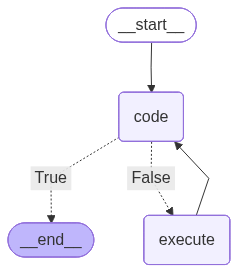

In [ ]:
data_analysis_graph

In [18]:
df

,Subject,System,ticket_id
0,LSM4.5 - B04 Firmware & Software List Import/E...,Operation System Support,47a21468-699b-4f7f-ab15-015aefcd63d6
1,VoLTE: CE-7a in BM0SBC11 in wrong state,Unified Access Gateway,b237e521-9c82-4382-baed-2f025ba09380
2,Server Group 10 Configuration on UAG,Unified Access Gateway,f8b6ff21-3756-48b9-9dca-2b6c027c432a
3,Query about AVP's on S-CSCF,Call Session Control Function,e10408b3-5d33-4e50-8cdc-d511f6009320
4,Query about AVP's on S-CSCF,Call Session Control Function,b6017fd8-7b62-48b7-95f7-b9c99cd335fb
...,...,...,...
2569,LNS ACCESS FAIL ALARM - mm.l2tp,Gateway General Packet Radio Service,cc9eb132-dc85-4514-b61c-c9acaf5f3374
2570,TS25A08V: VF-DE: Reduction in NR traffic in FS...,ACPF,d58c29b2-9a62-4372-9dcf-7e24b1fd4ead
2571,VoLTE HOSR Samsung KPI drop since 22/10/2025 0...,Distributed Unit,c114a79c-4aca-4635-a848-8401b7027453
2572,MCX Client Drop1 Testcase ID: Basic_005-001 Fa...,Smart phone,7d7ee4e4-cce1-460c-97dd-d2c51c9bb322


In [21]:
# Replace all instances of 'DU' with 'Distributed Unit' in the 'System' column
df['System'] = df['System'].str.replace('Gateway General Packet Radio Service', 'PGW', regex=False)

print("System column after replacement (sample unique values):")
print(df['System'].unique()[:50])




System column after replacement (sample unique values):
['Operation System Support' 'Unified Access Gateway'
 'Call Session Control Function' 'PGW' nan 'Domain Name Service'
 'C-MME/SGSN' 'Distributed Unit' 'CGW' 'RU' 'MRF' 'VMIG' 'SBC ' 'USM'
 'CaaS' 'RU(Samsung)' 'ACPF' 'vCMS' 'MMU(Samsung)' 'AUPF' 'Smart phone'
 'USM-R' 'DSO' 'CU' 'MMU' 'CSM' 'Presence']


In [22]:
df = df[df['System'] == 'PGW']

In [24]:
df.describe()

,Subject,System,ticket_id
count,202,202,202
unique,199,1,202
top,A1161 INTERNAL RESOURCE OVERLOAD,PGW,8a9f91de-637f-4fa2-9fc3-9da839877d3e
freq,2,202,1


In [25]:
df.to_csv('PGW_crm.csv', index=False)

In [2]:
df = pd.read_csv('PGW_crm.csv')

In [3]:
df['Subject'].to_list()

['Samsung TAC Incident (T160419009)- L2TP retransmissions',
 'Stale Tunnel carrying traffic - L2TP',
 'L2TP - Authemtication CHAP MD5 Reject - PAP clarification',
 'IPv6 Pool usage fault on BM0SAE01',
 'ERR_PCEF stats increasing when measuring SMAPN',
 'RuleBase creation error:Exceed Filter limit',
 "Using CCPF to switch off CDR's",
 'PCRF updates QoS but SAE doesnt apply to bearer',
 'PCRF downgrades QoS but SAE does not apply to PDP context',
 'ISCM Block Fail - Please refer to previous ticket - TS17A03P',
 'SAE-GW - incorrect user-password in RADIUS failure scenario',
 'FLT 7005 not visible in message history',
 'DNS NAPTRA Query for KNP Netherland APN failing',
 'HH0SAE03 LENA3 restart',
 'Threshold crossing alarm change request',
 'SAE-GW IMS CDRs',
 'LEMA CPU high usage Syslog',
 'Samsung 3GPPvendor ID',
 "Delete hang customers from SAE after APN's have been disabled.",
 'SAEGW - RADIUS  ACCOUNTING REQUEST   -  use of class field',
 'SAEGW is offloading subscribers when IP Pool i